In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
# get data     
df = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
df = df['gdp_total_season'].to_frame()
df['date'] = pd.to_datetime(df.index)

df.shape

(117, 2)

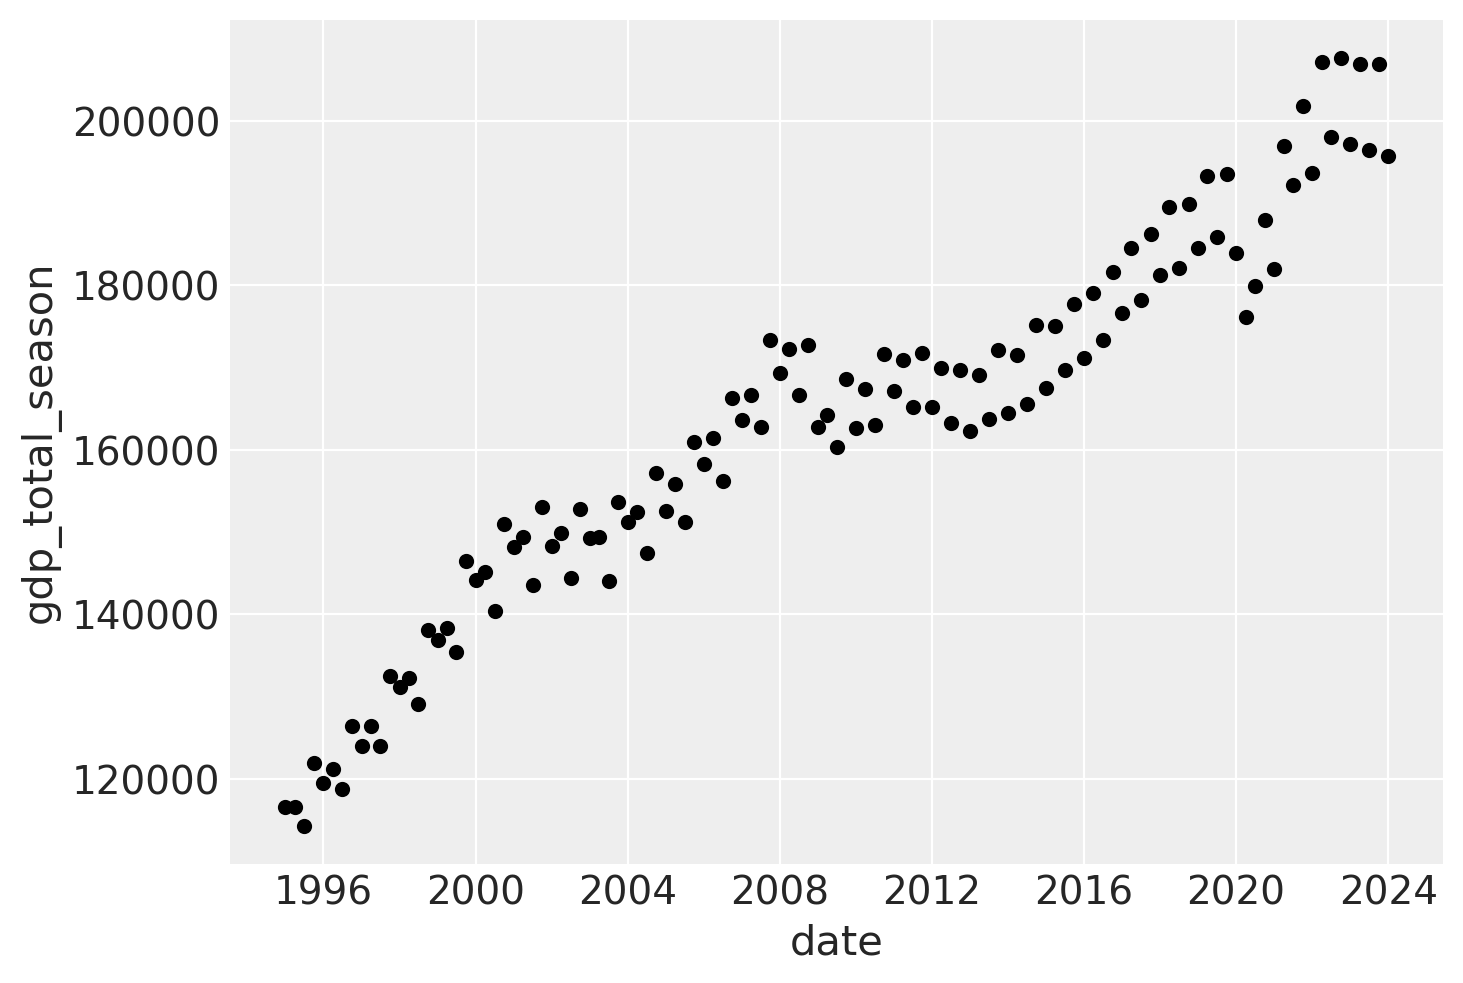

In [4]:
df.plot.scatter(x='date', y="gdp_total_season", color="k");

### Scale

In [14]:
t = (df["date"] - pd.Timestamp("1900-01-01")).dt.days.to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [6]:
y = df["gdp_total_season"].to_numpy()
y_max = np.max(y)
y = y / y_max

#### Linear trend

$
Passengers = \alpha + \Beta t
$

Sampling: [likelihood, α, β, σ]
/tmp/ipykernel_664/1731050332.py:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
/tmp/ipykernel_664/1731050332.py:22: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,


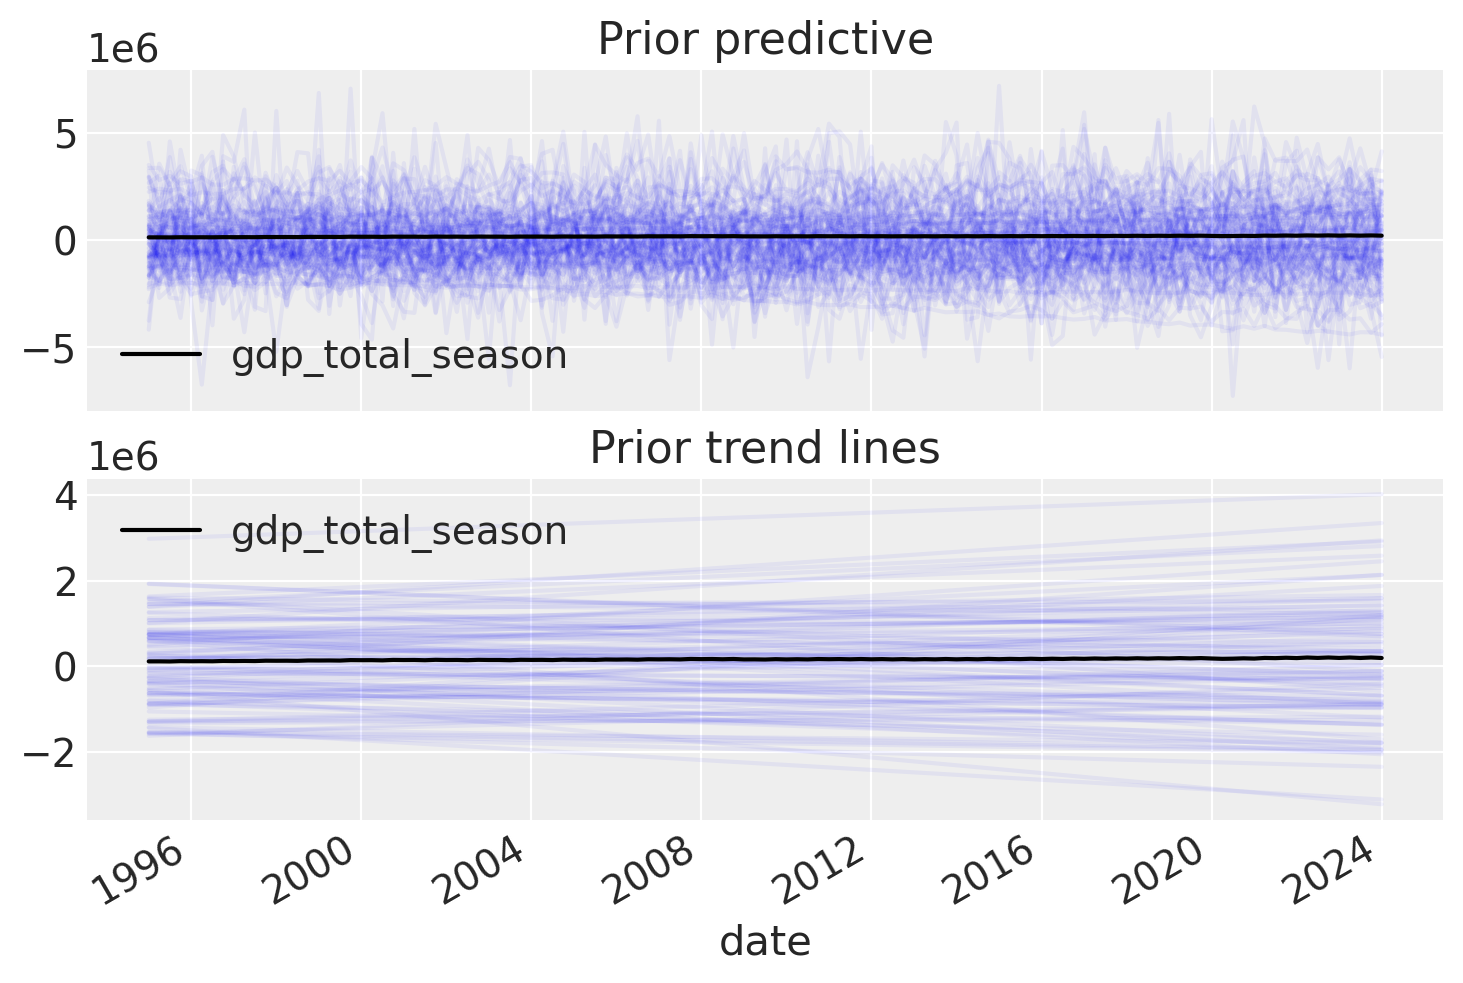

In [7]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=5)
    σ = pm.HalfNormal("σ", sigma=5)

    trend = pm.Deterministic("trend", α + β * t)
    
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["date"],
    az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["date"],
    az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");



##### Much to wide, retry

Sampling: [likelihood, α, β, σ]
/tmp/ipykernel_664/203213526.py:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
/tmp/ipykernel_664/203213526.py:22: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,


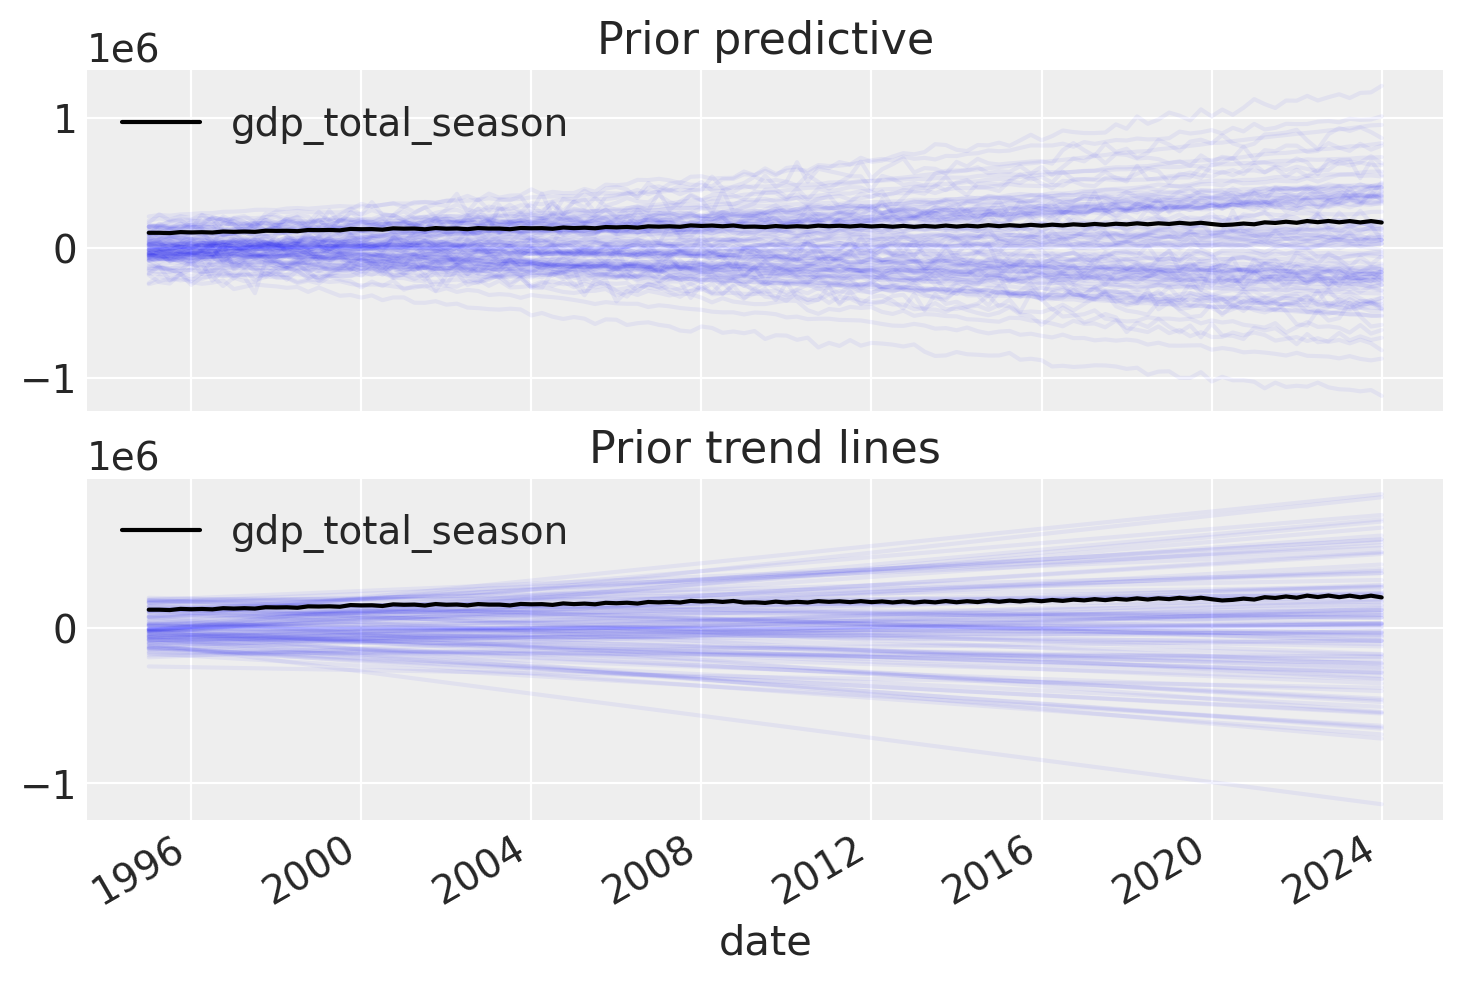

In [8]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=.5)
    β = pm.Normal("β", mu=0, sigma=2)
    σ = pm.HalfNormal("σ", sigma=.1)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["date"],
    az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["date"],
    az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [likelihood]


Output()

/tmp/ipykernel_664/4245467782.py:8: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
/tmp/ipykernel_664/4245467782.py:17: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,


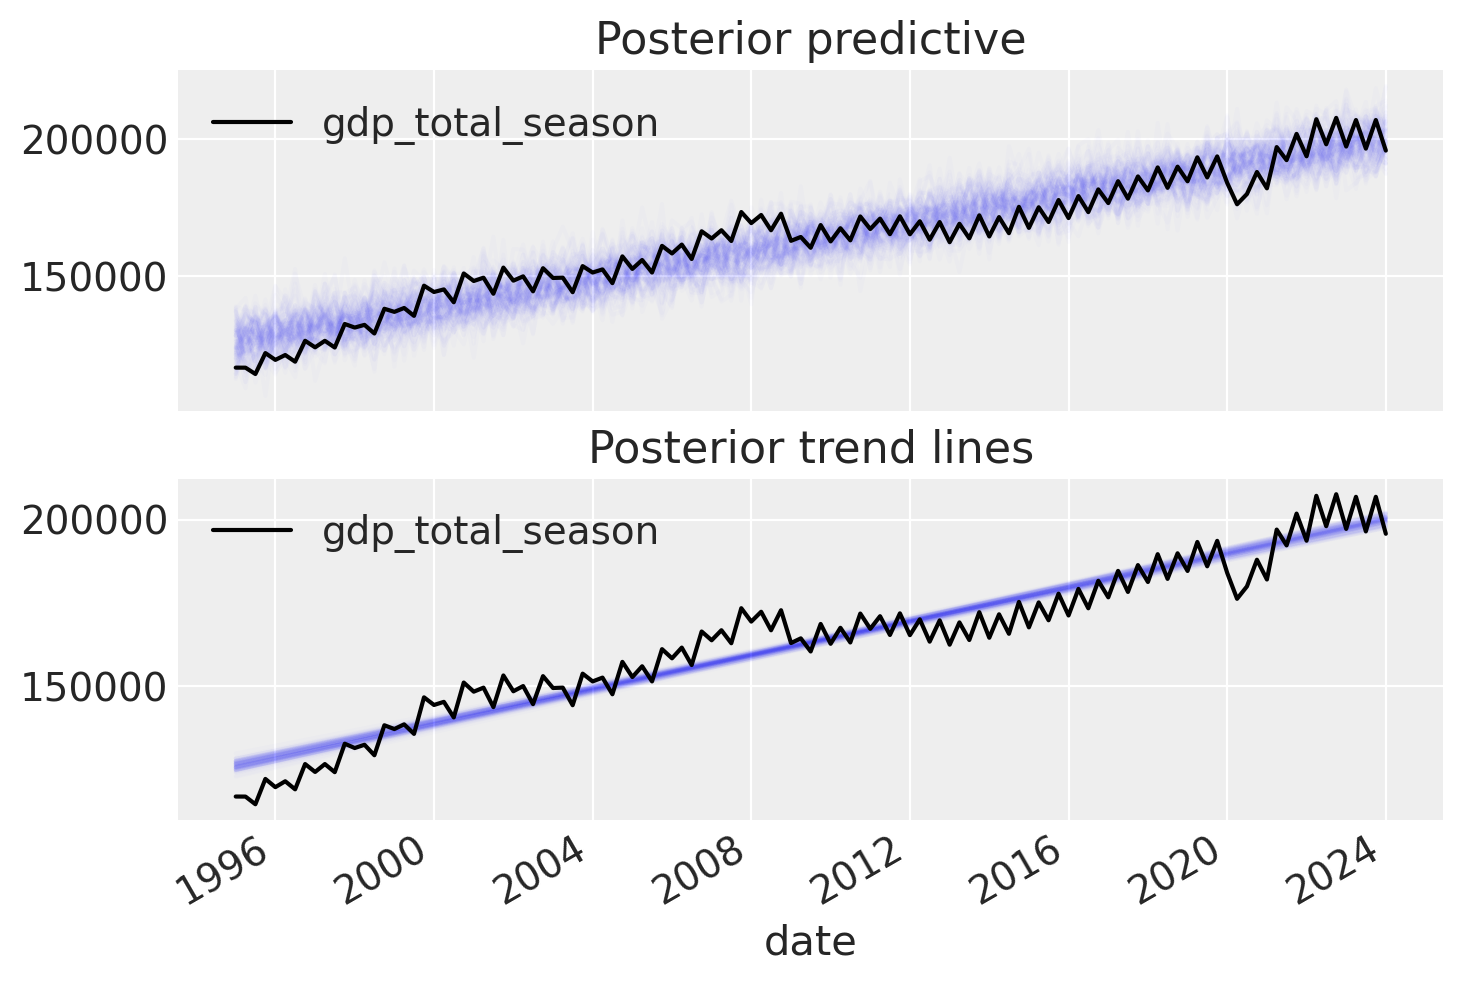

In [9]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["date"],
    az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.01,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["date"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");

### Seasonality

In [10]:

n_order = 5
periods = (df["date"] - pd.Timestamp("1900-01-01")).dt.days / 365.25

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
fourier_features

,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,sin_order_5,cos_order_5
1995-01-01,-0.012901,0.999917,-0.025801,0.999667,-0.038696,0.999251,-0.051584,0.998669,-0.064464,0.997920
1995-04-01,0.999371,0.035473,0.070900,-0.997483,-0.994341,-0.106239,-0.141444,0.989946,0.984306,0.176471
1995-07-01,0.040844,-0.999166,-0.081621,0.996663,0.122261,-0.992498,-0.162697,0.986676,0.202861,-0.979208
1995-10-01,-0.999579,-0.029025,0.058026,-0.998315,0.996210,0.086977,-0.115856,0.993266,-0.989485,-0.144636
1996-01-01,-0.017202,0.999852,-0.034398,0.999408,-0.051584,0.998669,-0.068755,0.997634,-0.085906,0.996303
...,...,...,...,...,...,...,...,...,...,...
2023-01-01,-0.012901,0.999917,-0.025801,0.999667,-0.038696,0.999251,-0.051584,0.998669,-0.064464,0.997920
2023-04-01,0.999371,0.035473,0.070900,-0.997483,-0.994341,-0.106239,-0.141444,0.989946,0.984306,0.176471
2023-07-01,0.040844,-0.999166,-0.081621,0.996663,0.122261,-0.992498,-0.162697,0.986676,0.202861,-0.979208
2023-10-01,-0.999579,-0.029025,0.058026,-0.998315,0.996210,0.086977,-0.115856,0.993266,-0.989485,-0.144636


Sampling: [likelihood, α, β, β_fourier, σ]
/tmp/ipykernel_664/3265360299.py:19: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
/tmp/ipykernel_664/3265360299.py:30: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
/tmp/ipykernel_664/3265360299.py:38: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:4]


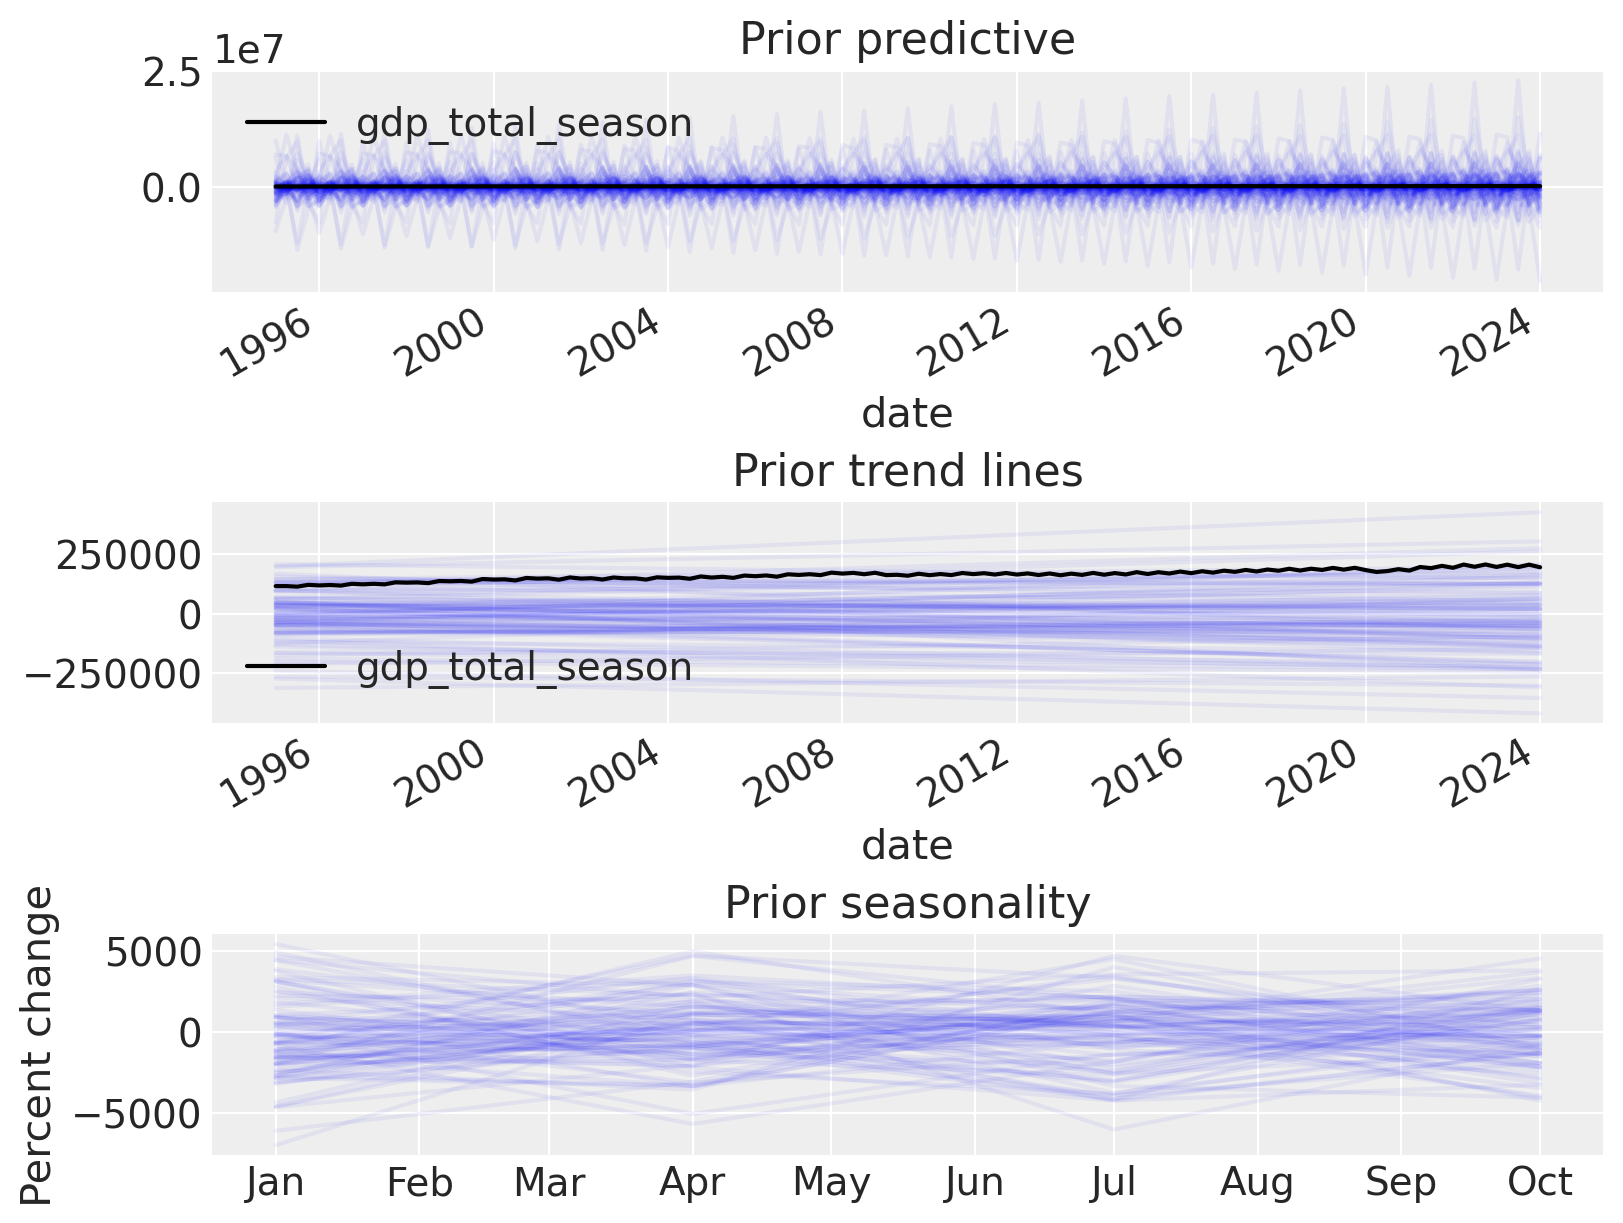

In [11]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    β_fourier = pm.Normal("β_fourier", mu=0, sigma=10, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_features.to_numpy().T)
    )
    trend = pm.Deterministic("trend", α + β * t)
    μ = trend * (1 + seasonality)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_seasonality_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(8, 6))
ax[0].plot(
    df["date"],
    az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
        "likelihood"
    ]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["date"],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["date"].iloc[:4],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:4]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Sampling: [likelihood, α, β, β_fourier, σ]
/tmp/ipykernel_664/2609500846.py:21: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
/tmp/ipykernel_664/2609500846.py:32: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
/tmp/ipykernel_664/2609500846.py:40: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:4]


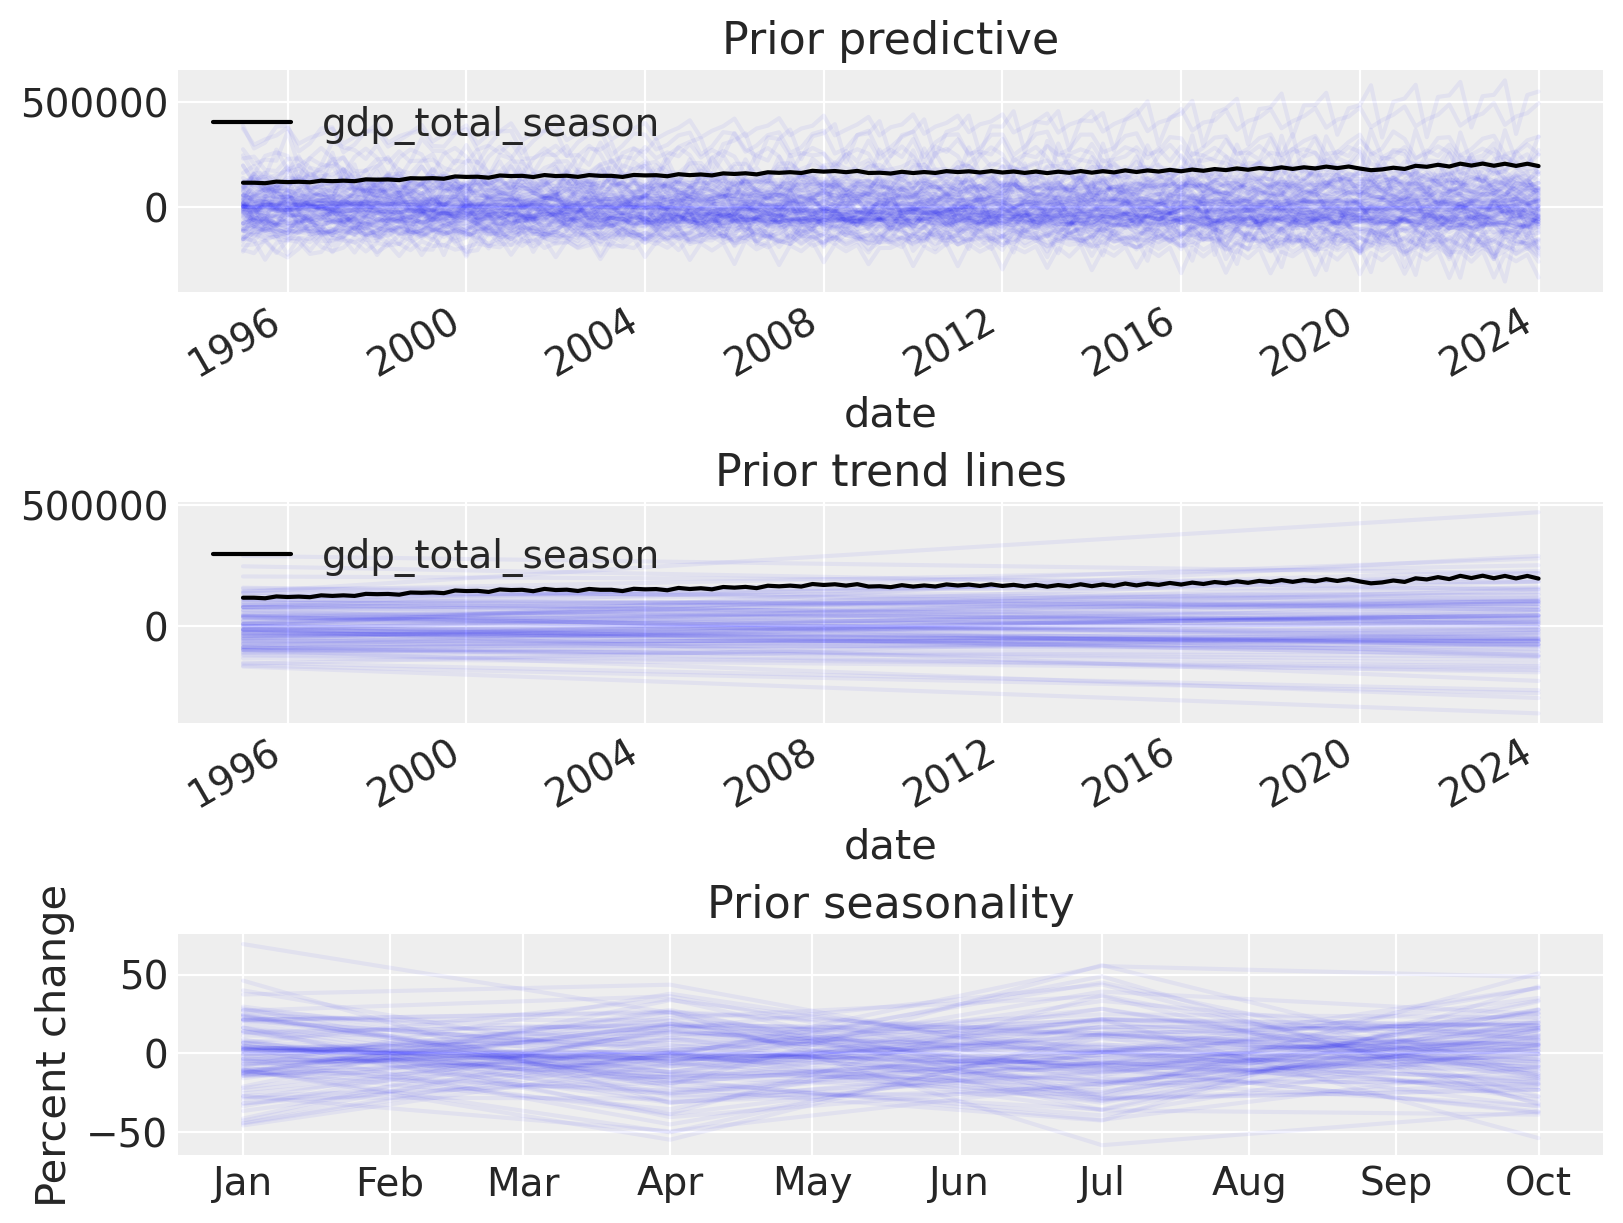

In [12]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    trend = pm.Deterministic("trend", α + β * t)

    β_fourier = pm.Normal("β_fourier", mu=0, sigma=0.1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_features.to_numpy().T)
    )

    μ = trend * (1 + seasonality)
    σ = pm.HalfNormal("σ", sigma=0.1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_seasonality_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(8, 6))
ax[0].plot(
    df["date"],
    az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
        "likelihood"
    ]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["date"],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["date"].iloc[:4],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:4]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, β_fourier, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [likelihood]


Output()

/tmp/ipykernel_664/2361792478.py:8: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_posterior, group="posterior_predictive", num_samples=100)[
/tmp/ipykernel_664/2361792478.py:19: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
/tmp/ipykernel_664/2361792478.py:27: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_trace, group="posterior", num_samples=100)["seasonality"][


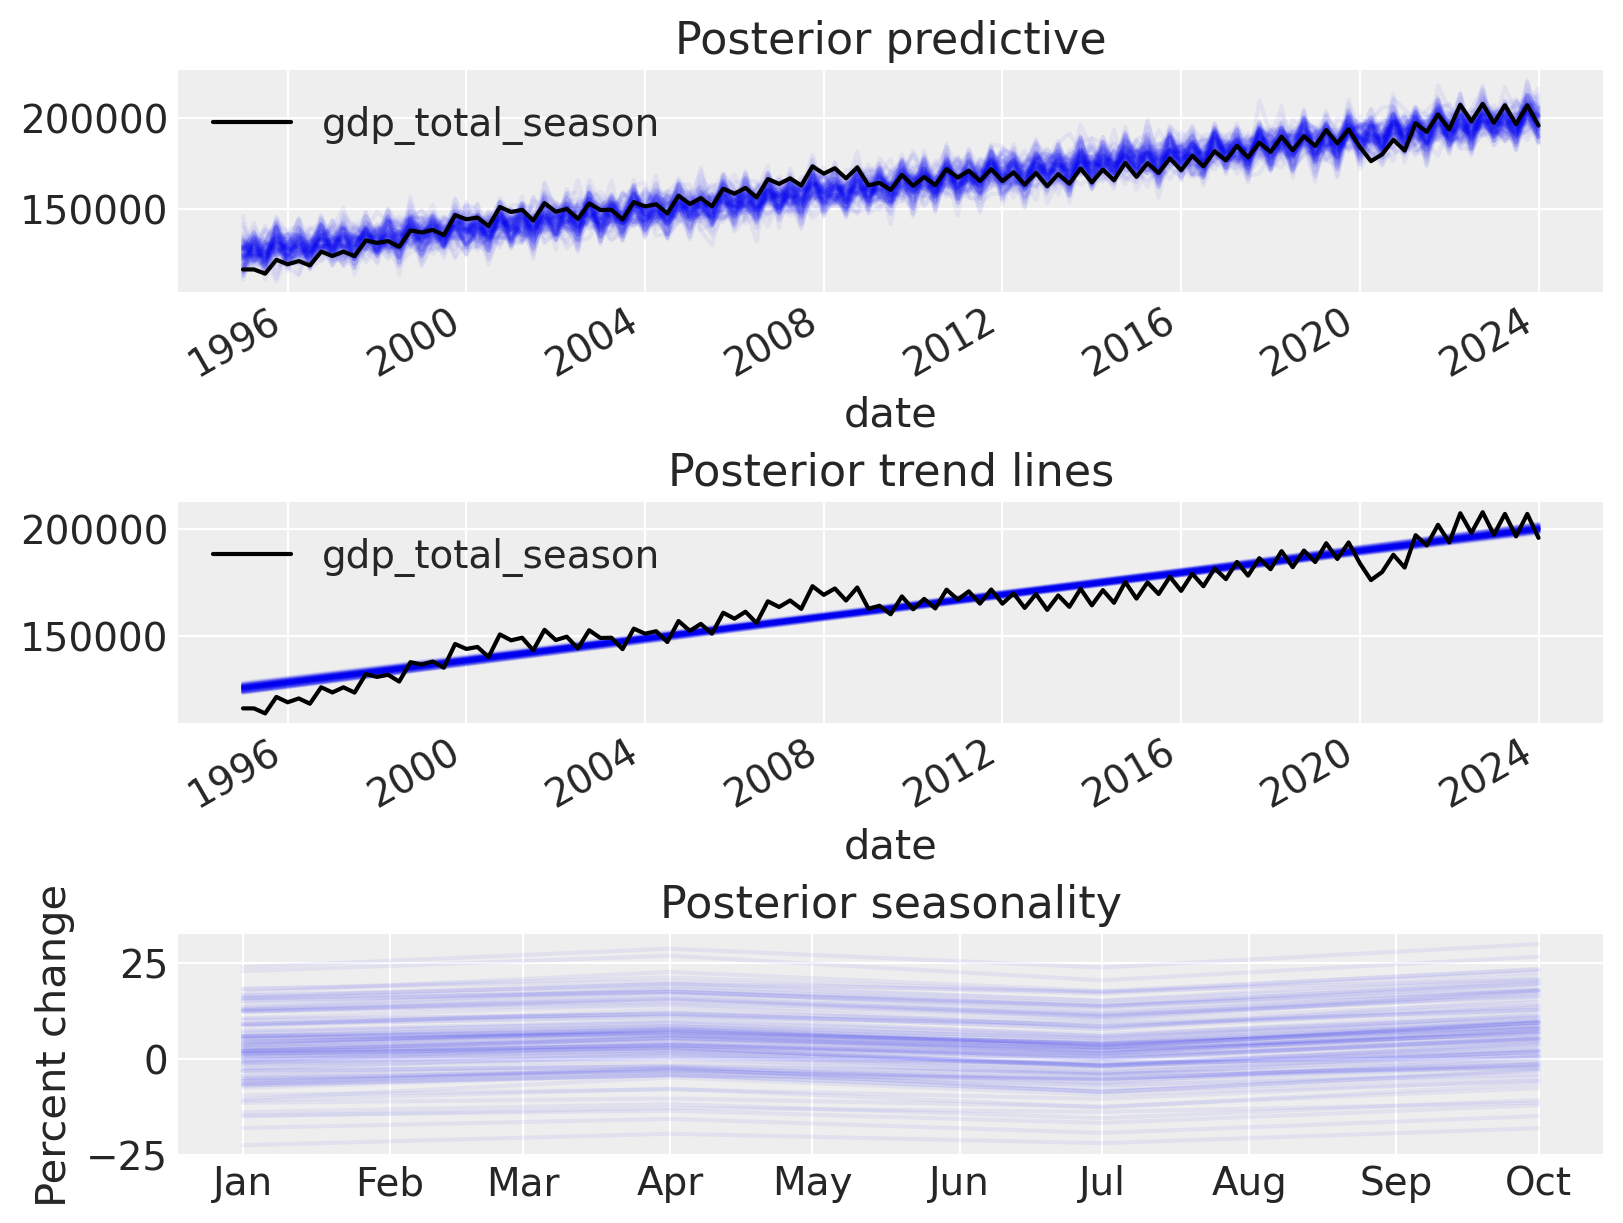

In [13]:
with linear_with_seasonality:
    linear_seasonality_trace = pm.sample(return_inferencedata=True)
    linear_seasonality_posterior = pm.sample_posterior_predictive(trace=linear_seasonality_trace)

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(8, 6))
ax[0].plot(
    df["date"],
    az.extract_dataset(linear_seasonality_posterior, group="posterior_predictive", num_samples=100)[
        "likelihood"
    ]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["date"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot(x="date", y="gdp_total_season", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines")
ax[2].plot(
    df["date"].iloc[:4],
    az.extract_dataset(linear_seasonality_trace, group="posterior", num_samples=100)["seasonality"][
        :4
    ]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Posterior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);